In [9]:
# import statements
import import_ipynb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from format_data import LoadAndFormatData
from bin_portfolio import BinPortfolio
from sharpe_ratio import SharpeRatio
from data_update_michael import FindCoefficients
import tqdm
import matplotlib.pyplot as plt

In [10]:
#Generates the Profit and Loss of a specific month using an investment, portfolio, and subset of data for a date
def generate_PnL(portfolio,subset,invest):
    pnl = 0
    #Gets the PERMNOs of companies of the bin in a list
    PERMNO = portfolio["PERMNO"].to_list()

    #Divides the investment easily between stocks
    moneyPerStock = invest/len(PERMNO)
    
    for company in PERMNO:
        #Gets the buy price and next month sell price of a stock
        buyPrc = subset.loc[subset['PERMNO'] == company, 'PRC'].values
        sellPrc = subset.loc[subset['PERMNO'] == company, 'PRC_t+1'].values
        #Generates the stockreturn plus intial amount invested
        pnl += moneyPerStock*(sellPrc/buyPrc)


    #REMOVE THIS BEFORE SUBMISSION, TESTS IF THERE IS NANS TODO
    if pd.isna(pnl):
        print("RACA YOU FOOL")
        for item in PERMNO:
            buyPrc = subset.loc[subset['PERMNO'] == item, 'PRC'].values
            sellPrc = subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values
            print(buyPrc, sellPrc)
        print('\n')
    return pnl

In [11]:
# Load and modify the data according to our function
df = LoadAndFormatData()
df.head()

,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv,RET_t+1,PRC_t+1,mkt
0,NaN,NaN,NaN,0.824752,NaN,1986-01-31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.257143,3.250000,0.009116
1,NaN,NaN,NaN,0.825905,NaN,1986-02-28,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.076998,0.212080,7804.560824,NaN,0.365385,4.437500,0.009116
2,NaN,NaN,NaN,0.825905,NaN,1986-03-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.055511,0.107977,3973.567637,-0.363314,-0.098592,4.000000,0.009116
3,NaN,NaN,NaN,0.825015,NaN,1986-04-30,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.037231,0.174533,6422.825870,-0.571056,-0.222656,3.109375,0.009116
4,NaN,NaN,NaN,0.824672,NaN,1986-05-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.048336,0.150228,5527.502665,-0.708679,-0.005025,3.093750,0.009116


In [12]:
dependent_var = ['RET']
regressors = ['mkt', 'roic', 'BEME', 'ME']
all_dataframe_vars = regressors + dependent_var + ['DATE', 'PERMNO', 'RET_t+1', 'PRC', 'PRC_t+1']
# NOTE: RET is used to find coefficients, RET_t+1 is used to evaluate the portfolio's success

sharpe_ratios = []
dates_with_data = []
pnl_curves = []
intial_investment = 100
sum = intial_investment

for month in tqdm.tqdm(sorted(df['DATE'].unique())):
    # Obtain the data for the month, dropping any rows with missing values in our selected variables
    currentData = df[df['DATE'] == month]
    currentData = currentData[all_dataframe_vars]
    currentData = currentData.dropna()
    if len(currentData.index) == 0:
        continue
    # Find the correct coefficients
    go_long = FindCoefficients(dataframe=currentData, regressors=regressors)
    # NOTE: This finds the coefficients for the t-th time period. 
    # Forming the portfolio on this would be assuming that the relationship for the next time period will be similar to the one for this time period.

    # Form the portfolio
    portfolio = BinPortfolio(dataframe=currentData, all_dataframe_vars=all_dataframe_vars, vars_to_bin=regressors, go_long=go_long)
    dates_with_data.append(month)
    # Calculate the Sharpe Ratio. These are calculated based on RET_t+1
    sharpe_ratios.append(SharpeRatio(portfolio=portfolio, df=df, rf=0))

    # Calculate the pnl curve using stocks from the bin and assuming that equal money is spent on each stock and the stock is sold at the end of the month TODO
    sum = generate_PnL(portfolio=portfolio, subset=currentData, invest=sum)
    pnl_curves.append(sum - 100)


100%|██████████| 828/828 [01:34<00:00,  8.77it/s]


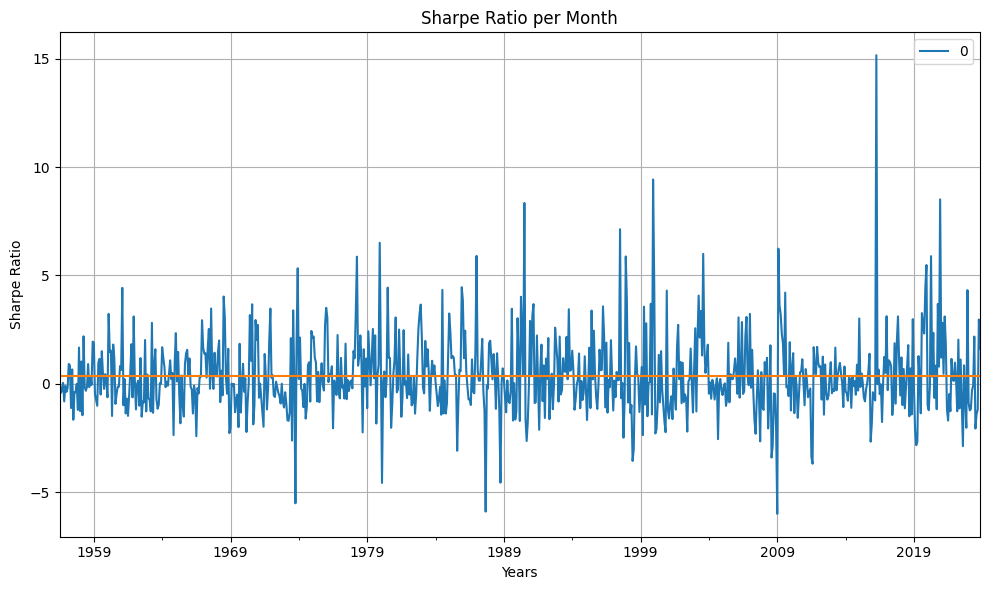

In [13]:
# Plot the sharpe ratio for each month
ax = plt.subplot()

sharpes = pd.DataFrame(sharpe_ratios, index=dates_with_data)
sharpes.plot(figsize=(10,6), ax=ax)
ax.set_xlabel("Years")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio per Month")
ax.grid()

ax.plot(sharpes.index, [np.mean(sharpes)] * len(sharpes.index))

plt.tight_layout()
plt.show()

In [14]:
np.mean(sharpes)

0.3693213851950822

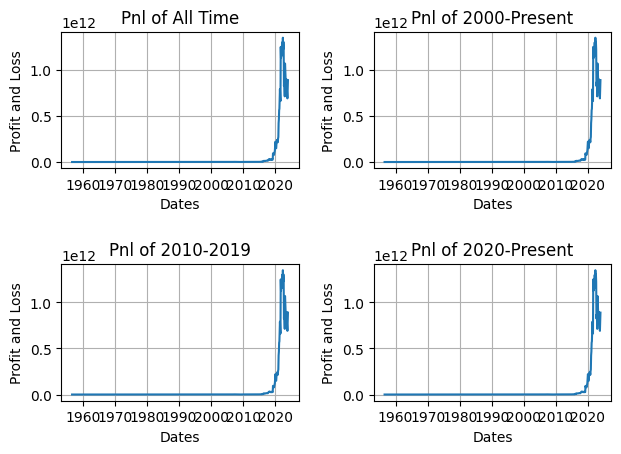

In [15]:
#This plots the Pnl over 4 time periods (all time, 2000-present, 2010-2019, 2020-present)
fig, axs = plt.subplots(2, 2)
# y0, y1 = 1e-12,5e-1

axs[0,0].set_title('Pnl of All Time') 
axs[0,0].plot(dates_with_data, pnl_curves)
axs[0,0].grid()

axs[0,1].set_title('Pnl of 2000-Present') 
axs[0,1].plot(dates_with_data, pnl_curves)
axs[0,1].grid()

axs[1,0].set_title('Pnl of 2010-2019') 
axs[1,0].plot(dates_with_data, pnl_curves)
axs[1,0].grid()

axs[1,1].set_title('Pnl of 2020-Present') 
axs[1,1].plot(dates_with_data, pnl_curves)
axs[1,1].grid()


for ax in axs.flat:
    ax.set(xlabel='Dates', ylabel='Profit and Loss')
fig.tight_layout()
plt.show()